# Project: Image Re-colorization using Unsupervised Model to People with Color Vision Deficiency (CVD)

## Libraries & Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dependencies
!pip install scikit-image
!pip install colormap
!pip install easydev
!pip install colormath

In [4]:
# Usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# computer vision and color
import cv2
from skimage.color import rgb2lab, deltaE_cie76
from colormap import rgb2hex
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# other
from collections import Counter

%matplotlib inline

---

## File Extraction

In [5]:
def get_image_rgb(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [6]:
# Extract filenames
image_files = glob.glob('/content/drive/MyDrive/DSI_CAPSTONE/*.jpg')

In [7]:
# Read file name into a dictionary
image_names = {}

for n,path in enumerate(image_files):
  var_name = 'image_'+str(n)
  image_names[var_name] = get_image_rgb(path)

In [8]:
# List of filenames
image_names.keys()

dict_keys([])

---

## Extracting Images to Different Channels

In [10]:
def show_image(image):
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(image)
    plt.show();

In [11]:
def show_layers(image):
    fig, axs = plt.subplots(1,4, figsize=(16,6))
    
    axs[0].imshow(image[:,:,0]/255, cmap = 'Reds')
    axs[1].imshow(image[:,:,1]/255, cmap = 'Greens')
    axs[2].imshow(image[:,:,2]/255, cmap = 'Blues')
    axs[3].imshow(image)
    
    axs[0].set_title('Red')
    axs[1].set_title('Green')
    axs[2].set_title('Blue')
    axs[3].set_title('All')
    
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    axs[3].axis('off')
    
    plt.show();

In [16]:
for n,img in enumerate(image_names.keys()):
  print(img)
  show_layers(image_names[img])

In [15]:
# Plotting distribution of RGB intensity
plt.figure(figsize=(15, 12))

for n,img in enumerate(image_names.keys()):
  ax = plt.subplot(3,2,n+1)
  for i in range(3):
    colors = ['r','g','b']
    img_df = pd.DataFrame(image_names[img][:,:,i].flatten(),
                          columns=['intensity'])
    ax = sns.kdeplot(img_df['intensity'],color=colors[i])

<Figure size 1080x864 with 0 Axes>

In [12]:
# Variable of all channels of R, G, B is similar

---

## KMeans Clustering to Extract Major Colors

In [13]:
def kmeans_get_colors(image,num_of_colors):


  # modify image
  mod_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
  mod_image = mod_image.reshape(mod_image.shape[0]*mod_image.shape[1], 3)

  # clf
  clf = KMeans(n_clusters = num_of_colors)  

  # labels
  labels = clf.fit_predict(mod_image)
  counts = Counter(labels)
  center_colors = clf.cluster_centers_
  ordered_colors = [center_colors[i] for i in counts.keys()]
  rgb_colors = [ordered_colors[i] for i in counts.keys()]
  rgba_colors = [ordered_colors[i]/255 for i in counts.keys()]

  # plot
  fig, axs = plt.subplots(1,2,figsize = (8,6))
  axs[0].imshow(image)
  axs[0].axis("off")
  axs[1].pie(counts.values(), colors = rgba_colors)
  plt.show()

  return rgb_colors

image_0


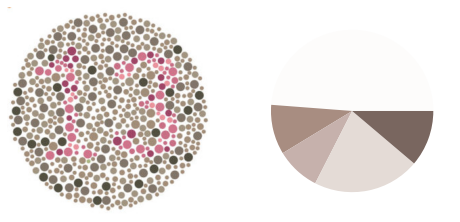

image_1


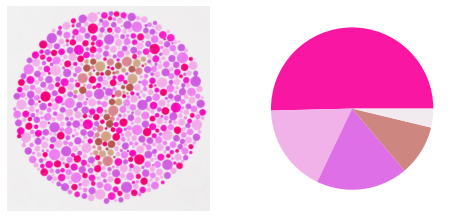

image_2


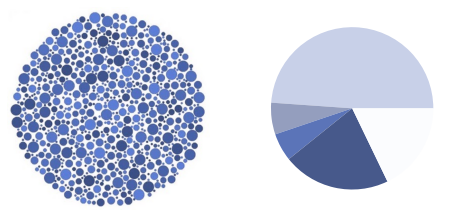

image_3


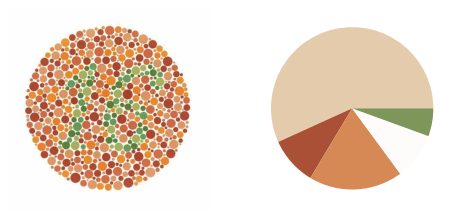

image_4


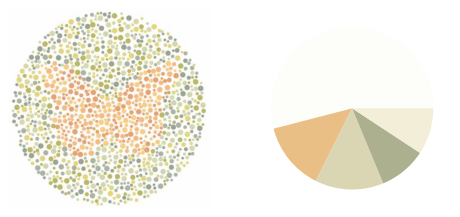

image_5


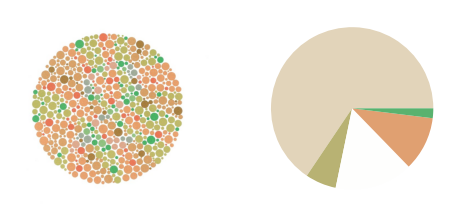

In [42]:
for n,img in enumerate(image_names.keys()):
  print(img)
  kmeans_get_colors(image_names[img],5)

---

## Using KMeans to Recolor by Grouping Similar Colors

In [17]:
def compare_two_image(image,recolored_img):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    # original photo
    ax1.imshow(image)
    ax1.axis("off")
    ax1.set_title('Original')

    # Recolored
    ax2.imshow(recolored_img)
    ax2.axis("off")
    ax2.set_title('Recolored')

In [21]:
def recolor_image(image,num_color = 2):
    # Recolor image based on number of color cluster

    # reshape image to array
    reshaped_image = image.reshape(image.shape[0]*image.shape[1], 3)

    # instantiate kmeans & fit_predict
    clf = KMeans(n_clusters = num_color)
    labels = clf.fit_predict(reshaped_image)

    # count predicted labels
    counts = Counter(labels)

    # centers of colors
    center_colors = clf.cluster_centers_

    # Generating predicted class dataframe
    # reshaped image is 2D array
    pred_df = pd.DataFrame(reshaped_image,columns=['R','G','B'])
    pred_df['class'] = labels

    # RGB color of cluster center color
    new_color_df = pd.DataFrame(center_colors/255)
    new_color_df['class'] = new_color_df.index

    # Merging original color and class with new color
    image_df = pd.merge(pred_df, new_color_df, 
                    how='left', 
                    on='class')

    # Reshape recolored image
    recolored_image = image_df[[0,1,2]].to_numpy().reshape(image.shape[0],
                                                           image.shape[1],3)

    compare_two_image(image,recolored_image)

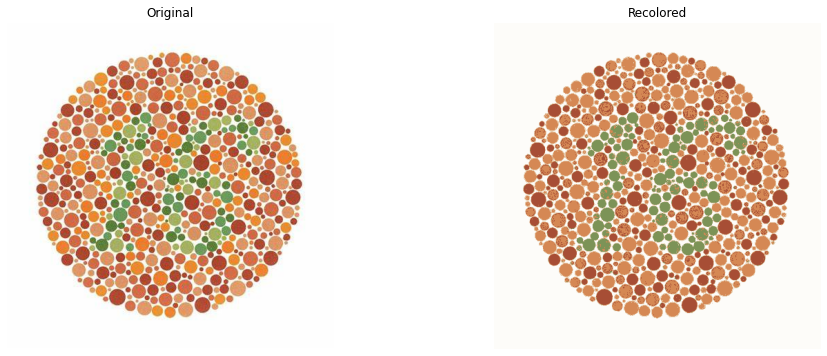

In [24]:
recolor_image(image_names['image_3'],5)

In [25]:
# For colorblind, KMeans to regroup similar color in the same image together
# many not help all the time because colorblind has trouble telling similar
# colors apart. So sometimes the color gets grouped together, making the 
# pattern even more invisible.

---

## Grouping of Similar Colors to Create Main Color for Mapping

In [34]:
color_df = pd.read_csv('/content/drive/MyDrive/DSI_CAPSTONE/color-names/output/colors.csv', header = None)
color_df.columns = ['name','name_2','hex','R','G','B']
color_rgb = color_df[['R','G','B']]

In [36]:
# KMeans to cluster up colors
k_list = []
sil_list = []
inertia_list = []

for num in range(2,200,2):
    clf = KMeans(n_clusters = num)
    label = clf.fit_predict(color_rgb)
    k_list.append(num)
    sil_list.append(silhouette_score(color_rgb,label))
    inertia_list.append(clf.inertia_)
    
results = pd.DataFrame({'k':k_list,'sil_score':sil_list,'inertia':inertia_list})

In [50]:
results['inertia_2'] = results['inertia'].shift(1)

In [53]:
results['inertia_diff'] = results['inertia_2']-results['inertia']

In [54]:
results

,k,sil_score,inertia,inertia_2,inertia_diff
0,2,0.298859,1.135309e+07,NaN,NaN
1,4,0.317164,6.462933e+06,1.135309e+07,4.890155e+06
2,6,0.315242,4.650180e+06,6.462933e+06,1.812753e+06
3,8,0.309883,3.818609e+06,4.650180e+06,8.315714e+05
4,10,0.296033,3.275975e+06,3.818609e+06,5.426335e+05
...,...,...,...,...,...
94,190,0.356618,1.920877e+05,1.945151e+05,2.427385e+03
95,192,0.356343,1.895122e+05,1.920877e+05,2.575461e+03
96,194,0.362193,1.869930e+05,1.895122e+05,2.519228e+03
97,196,0.367420,1.842917e+05,1.869930e+05,2.701259e+03


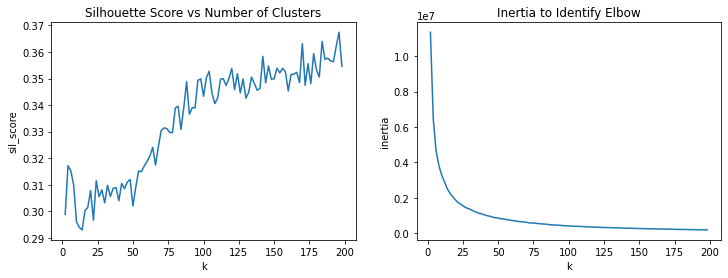

In [37]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

axs[0].set_title('Silhouette Score vs Number of Clusters')
sns.lineplot(x='k',y='sil_score', data=results, ax=axs[0])

axs[1].set_title('Inertia to Identify Elbow')
sns.lineplot(x='k',y='inertia', data=results, ax=axs[1]);

In [38]:
# Clustering to identify color center

# From elbow method, 25 clusters seems to be the optimum choice
clf = KMeans(n_clusters = 25)
label = clf.fit_predict(X_train)

# Generate color centers
center_colors = clf.cluster_centers_
counts = Counter(label)
rgb_colors = [center_colors[i] for i in counts.keys()]

# Divide by 255 to use as color plot below
rgba_colors = [center_colors[i]/255 for i in counts.keys()]

In [ ]:
# Forming dataframe to main image colors to the main
# creating a dataframe 
main_color_df = pd.DataFrame(rgb_colors,columns=['R','G','B'])
main_color_df['main_cluster'] = main_color_df.index

# add white
white = pd.DataFrame({'R':255, 'G':255, 'B':255,
                      'main_cluster':main_color_df.shape[0]},
                     index=[main_color_df.shape[0]])
main_color_df = main_color_df.append(white)

# add black
black = pd.DataFrame({'R':0, 'G':0, 'B':0,
                      'main_cluster':main_color_df.shape[0]},
                     index=[main_color_df.shape[0]])
main_color_df = main_color_df.append(black)

# check df
main_color_df

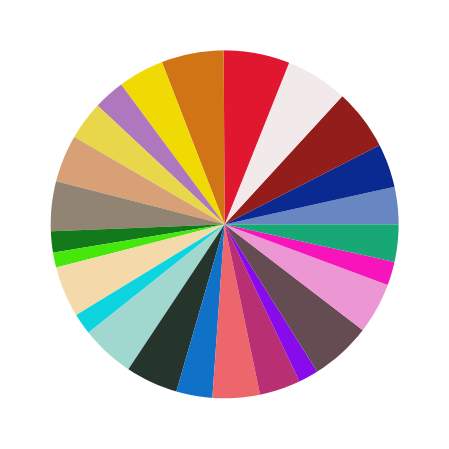

In [43]:
# Showing the main colors from clustering
plt.figure(figsize=(8,8))

plt.pie(counts.values(),colors = rgba_colors)
plt.show()

---

## Formula to calculate distance between colors

**Delta E is measured on a scale from 0 to 100, where 0 is less color difference, and 100 indicates complete distortion. As explained in this guide by Zachary Schuessler, standard perception ranges are as follows:**

<= 1.0: Not perceptible by the human eye <br>
1-2: Perceptible through close observation <br>
2-10: Perceptible at a glance <br>
11-49: Colors are more similar than the opposite <br>
100: Colors are exactly the opposite <br>

We can use how similar these colors are to reassign major color


In [44]:
def compute_deltaE(color1,color2):
  # Calculate Delta E from input of two colors in RGB format

  # Convert to sRGB
  color1_sRGB = sRGBColor(color1['R'],color1['G'],color1['B'])
  color2_sRGB = sRGBColor(color2['R'],color2['G'],color2['B'])

  # Convert to LAB
  color1_LAB = convert_color(color1_sRGB, LabColor)
  color2_LAB = convert_color(color2_sRGB, LabColor)

  # Computer distance
  delta_e = delta_e_cie2000(color1_LAB, color2_LAB);

  return delta_e

---

## Checking the image recolorising formula

In [45]:
image = image_names['image_5']

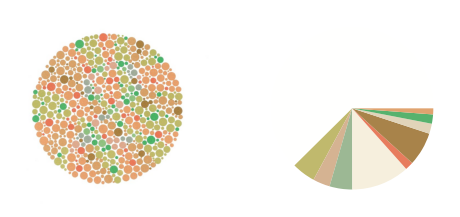

In [46]:
# extract image color
image_color = pd.DataFrame(kmeans_get_colors(image,10),columns=['R','G','B'])

In [47]:
def recolor_main(image,num_color):
  # Prepare image for KMeans
  # Reshape image
  mod_image = image.reshape(image.shape[0]*image.shape[1], 3)

  # Original image df
  pred_df = pd.DataFrame(mod_image,columns=['R','G','B'])

  # Clf fit_predict and generate cluster centers
  clf = KMeans(n_clusters = num_color)
  labels = clf.fit_predict(mod_image)
  counts = Counter(labels)
  center_colors = clf.cluster_centers_

  # Assign class
  pred_df['class'] = labels

  # Matching with main color cluster
  # storing clusters
  cluster = []

  for id in image_color.index:
    # blank Es to store delta e's 
    delta_Es = []

    # loop through cluster to identify closest cluster
    for clus in main_color_df.index:
      delta_Es.append(compute_deltaE(image_color.loc[id],main_color_df.loc[clus]))
    
    # identify closest cluster
    cluster.append(delta_Es.index(min(delta_Es)))

  image_color['main_cluster'] = cluster
  image_color['class'] = image_color.index

  # Merging
  recolor = pd.merge(pd.merge(pred_df,image_color[['class','main_cluster']], how='left', on='class'),
          main_color_df,how='left', on='main_cluster',suffixes=('_old','_new'))[['R_new','G_new','B_new']]/255

  # Reshape recolored image
  recolored_image = recolor.to_numpy().reshape(image.shape[0],image.shape[1],3)

  # Show color comparison
  compare_two_image(image,recolored_image)

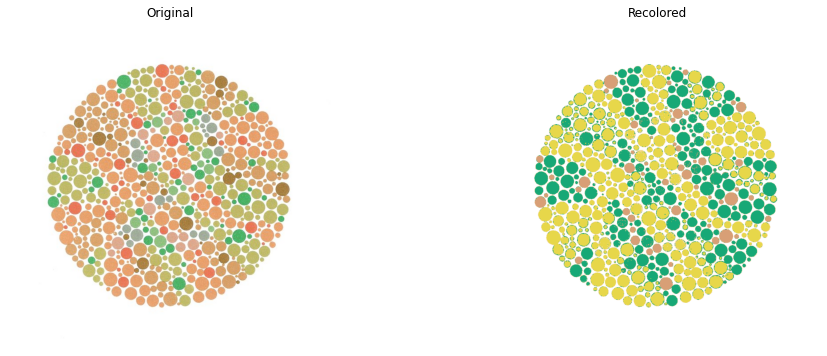

In [48]:
recolor_main(image,5)

In [184]:
# How to identify the optimum number of colors to extract?
# Resize image to certain pixels and interpolate
# 

---